In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from trainer import Trainer
from utils import load_mnist

In [3]:
from argparse import Namespace

config = {
    'train_ratio': .8,
    'batch_size' : 64,
    'n_epochs' : 50,
    'verbose' : 1,
    'btl_size' : 2
}

config = Namespace(**config)
print(config)

Namespace(batch_size=64, btl_size=2, n_epochs=50, train_ratio=0.8, verbose=1)


In [4]:
def show_image(x):
    if x.dim() == 1:
        x = x.view(int(x.size(0) ** .5), -1)
        
    plt.imshow(x, cmap = 'gray')
    plt.show()

In [5]:
train_x, train_y = load_mnist(flatten = True)
test_x, test_y = load_mnist(is_train = False, flatten = True)

train_cnt = int(train_x.size(0) * config.train_ratio)
valid_cnt = train_x.size(0) - train_cnt

In [6]:
indices = torch.randperm(train_x.size(0))

train_x = torch.index_select(train_x, dim = 0, index = indices)
train_y = torch.index_select(train_y, dim = 0, index = indices)

train_x, valid_x = train_x.split([train_cnt, valid_cnt], dim = 0)
train_y, valid_y = train_y.split([train_cnt, valid_cnt], dim = 0)

print("Train: ", train_x.shape, train_y.shape)
print("Valid: ", valid_x.shape, valid_y.shape)
print("Test: ", test_x.shape, test_y.shape)

Train:  torch.Size([48000, 784]) torch.Size([48000])
Valid:  torch.Size([12000, 784]) torch.Size([12000])
Test:  torch.Size([10000, 784]) torch.Size([10000])


In [7]:
from model import Autoencoder

In [8]:
model = Autoencoder(btl_size = config.btl_size)
optimizer = optim.Adam(model.parameters())
crit = nn.MSELoss()

trainer = Trainer(model, optimizer, crit)

In [9]:
trainer.train((train_x, train_x), (valid_x, valid_x), config)

Epoch(1/50): train_loss=5.9175e-02  valid_loss=4.7445e-02  lowest_loss=4.7445e-02
Epoch(2/50): train_loss=4.8225e-02  valid_loss=4.3783e-02  lowest_loss=4.3783e-02
Epoch(3/50): train_loss=4.5917e-02  valid_loss=4.3110e-02  lowest_loss=4.3110e-02
Epoch(4/50): train_loss=4.4660e-02  valid_loss=4.1966e-02  lowest_loss=4.1966e-02
Epoch(5/50): train_loss=4.4053e-02  valid_loss=4.1352e-02  lowest_loss=4.1352e-02
Epoch(6/50): train_loss=4.3326e-02  valid_loss=4.0394e-02  lowest_loss=4.0394e-02
Epoch(7/50): train_loss=4.2761e-02  valid_loss=4.0586e-02  lowest_loss=4.0394e-02
Epoch(8/50): train_loss=4.2097e-02  valid_loss=3.9735e-02  lowest_loss=3.9735e-02
Epoch(9/50): train_loss=4.1636e-02  valid_loss=3.9517e-02  lowest_loss=3.9517e-02
Epoch(10/50): train_loss=4.1437e-02  valid_loss=3.8696e-02  lowest_loss=3.8696e-02
Epoch(11/50): train_loss=4.1137e-02  valid_loss=3.9347e-02  lowest_loss=3.8696e-02
Epoch(12/50): train_loss=4.0920e-02  valid_loss=3.9352e-02  lowest_loss=3.8696e-02
Epoch(13/50):

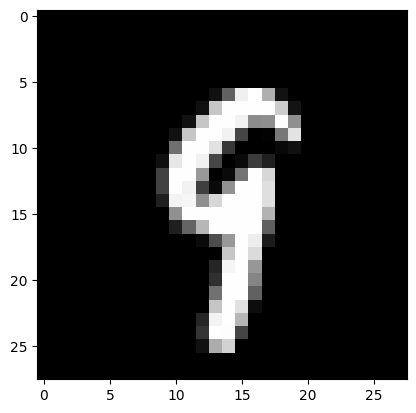

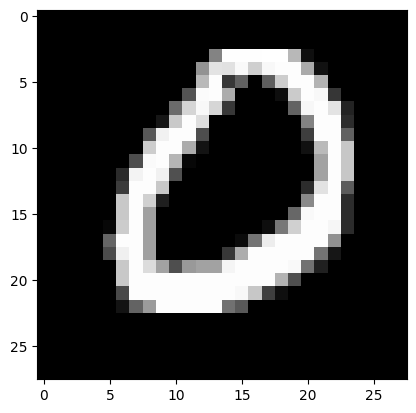

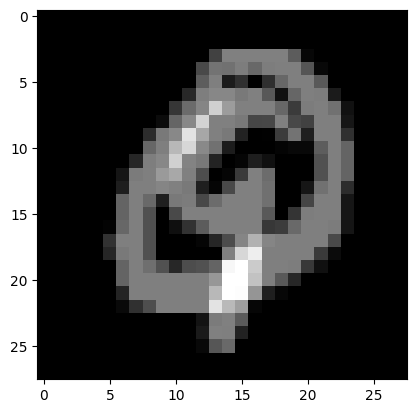

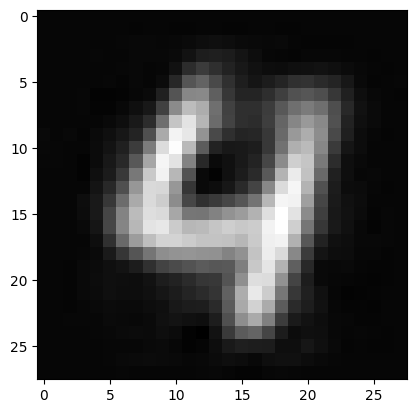

In [10]:
with torch.no_grad():
    import random
    
    index1 = int(random.random() * test_x.size(0))
    index2 = int(random.random() * test_x.size(0))
    
    z1 = model.encoder(test_x[index1].view(1, -1))
    z2 = model.encoder(test_x[index2].view(1, -1))
    
    recon = model.decoder((z1 + z2)/2).squeeze()
    
    show_image(test_x[index1])
    show_image(test_x[index2])
    show_image((test_x[index1] + test_x[index2]) / 2)
    show_image(recon)

In [16]:
test_y.shape

torch.Size([10000])

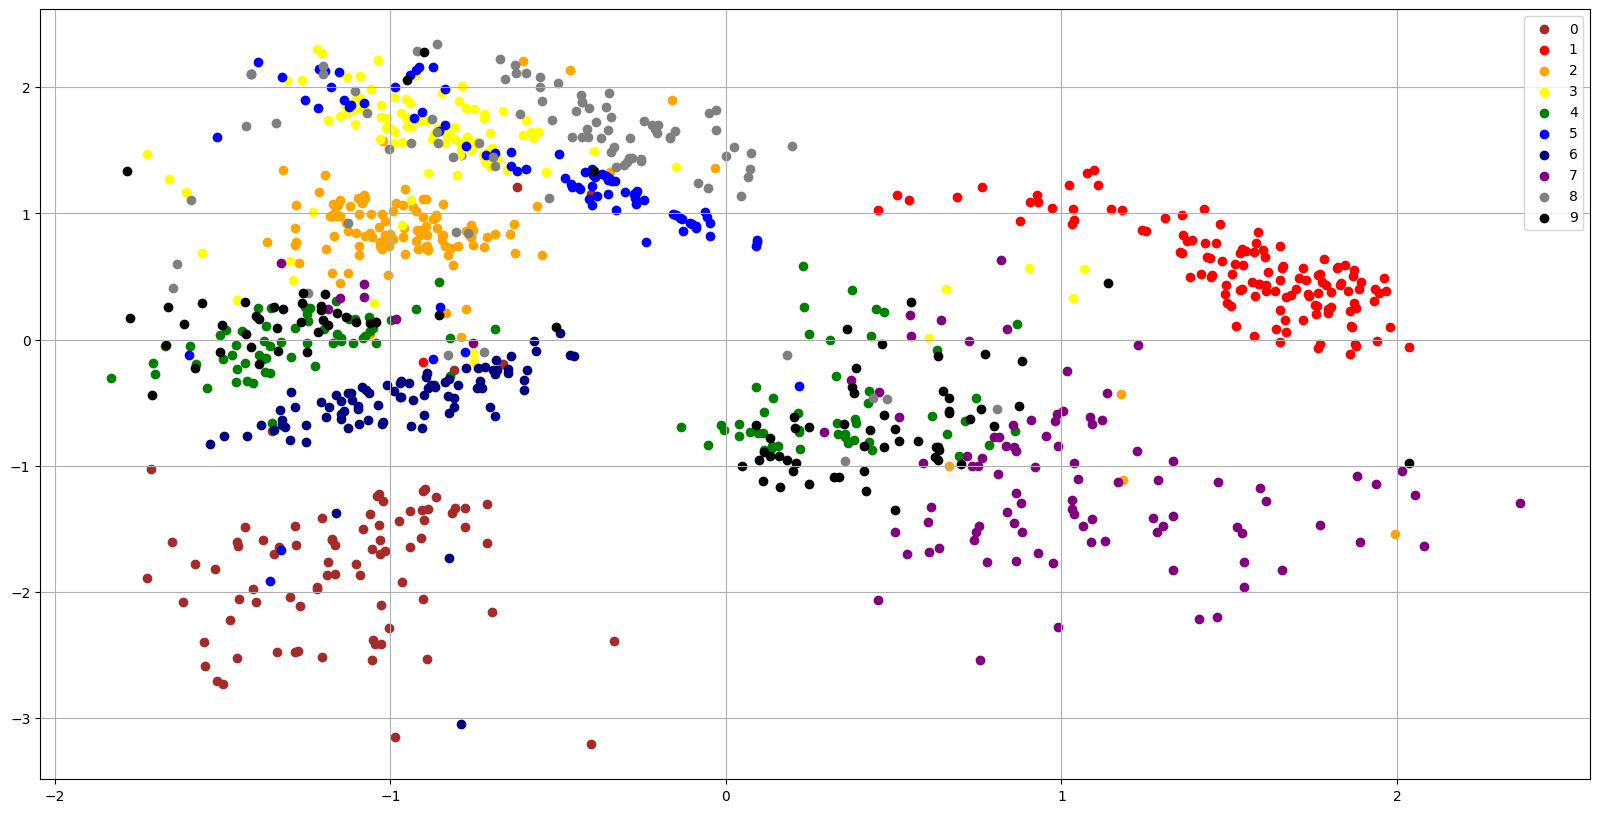

In [22]:
if config.btl_size == 2:
    color_map = ['brown', 'red', 'orange', 'yellow', 'green', 'blue','navy', 'purple', 'gray', 'black']
    
    plt.figure(figsize=(20, 10))
    with torch.no_grad():
        latents = model.encoder(test_x[:1000])
        
        for i in range(10):
            target_latents = latents[test_y[:1000]==i]
            target_y = test_y[:1000][test_y[:1000]==i]
            plt.scatter(target_latents[:, 0] , 
                       target_latents[:, 1],
                       marker = 'o',
                       color = color_map[i],
                       label = i)
            
        plt.legend()
        plt.grid(axis = 'both')
        plt.show()

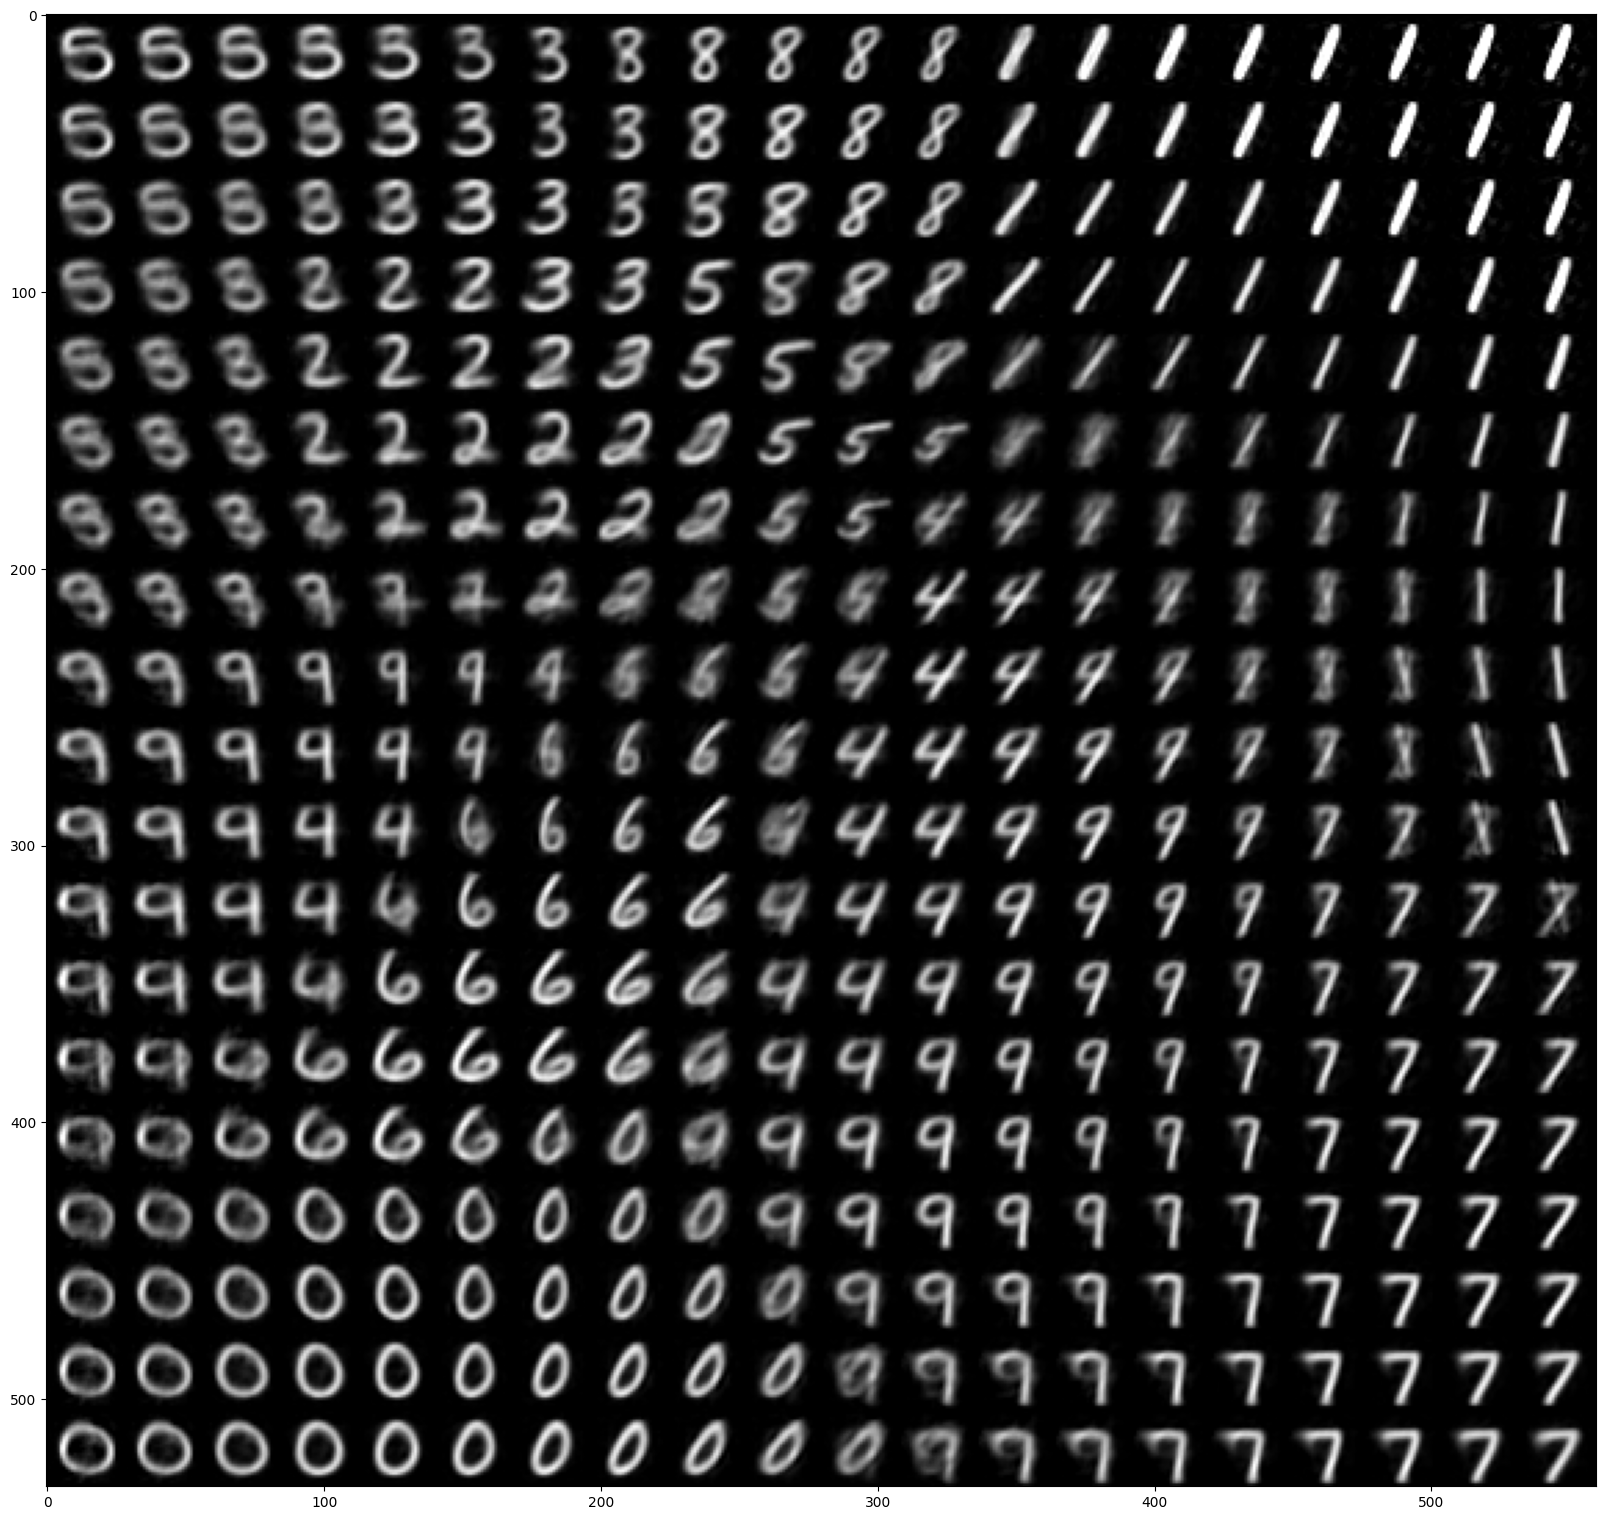

In [26]:
if config.btl_size == 2:
    min_range, max_range = -2, 2
    n = 20
    
    step = (max_range - min_range) / float(n)
    
    with torch.no_grad():
        lines = []
        
        for v1 in np.arange(min_range, max_range, step):
            z = torch.stack([
                torch.FloatTensor([v1] * n),
                torch.FloatTensor([v2 for v2 in np.arange(min_range, max_range, step)]),],
                dim = -1)
            line = torch.clamp(model.decoder(z).view(n, 28, 28), 0, 1)
            line = torch.cat([line[i] for i in range(n-1, 0, -1)], dim=0)
            lines += [line]
            
        lines = torch.cat(lines, dim = -1)
        plt.figure(figsize = (20, 20))
        show_image(lines)